# SETUP AND LIBRARY IMPORTS

In [1]:
!pip install -q torchxrayvision
!pip install -q grad-cam

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import time
from scipy import stats
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import torchxrayvision as xrv
from torchxrayvision.datasets import imread, apply_transforms
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix
from tqdm.notebook import tqdm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  G

# EXPERIMENT CONFIGURATION

In [2]:
class CFG:
    DATA_DIR = "/kaggle/input/padchest-buat-ta/"
    SUBFOLDERS = ["folder_1", "folder_2", "folder_3"]
    CSV_PATH = "/kaggle/input/padchest-buat-ta/PADCHEST.csv"
    
    DENSENET_WEIGHTS = "/kaggle/input/dense-and-vit-v2/pytorch/default/1/best_model_densenet_focal v2.pth"
    VIT_WEIGHTS = "/kaggle/input/dense-and-vit-v2/pytorch/default/1/best_model_vit_b_16_focal v2.pth"

    # Parameters
    IMG_SIZE = 224
    BATCH_SIZE = 32
    SEED = 2025
    TARGET_LABELS = ["Infiltration", "Effusion"]

# HELPER CLASSES

In [3]:
# Loss Function Class
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * bce_loss
        valid_mask = ~torch.isnan(targets)
        if self.reduction == 'mean': return torch.mean(focal_loss[valid_mask])
        elif self.reduction == 'sum': return torch.sum(focal_loss[valid_mask])
        else: return focal_loss

In [4]:
# Custom Dataset Class
class PadChestMultiFolderDataset(xrv.datasets.PC_Dataset):
    def __init__(self, imgpath, subfolders, **kwargs):
        self.subfolders = subfolders
        super().__init__(imgpath=imgpath, **kwargs)
    def __getitem__(self, idx):
        sample = {"idx": idx, "lab": self.labels[idx]}
        imgid = self.csv['ImageID'].iloc[idx]
        found_path = None
        for folder in self.subfolders:
            potential_path = os.path.join(self.imgpath, folder, folder, imgid)
            if os.path.exists(potential_path):
                found_path = potential_path
                break
        if found_path is None: raise FileNotFoundError(f"{imgid} not found")
        img = imread(found_path)
        img = img.astype(np.float32) / 65535.0
        sample["img"] = img
        sample = apply_transforms(sample, self.transform)
        sample = apply_transforms(sample, self.data_aug)
        return sample["img"], sample["lab"]

# FUNCTIONS DEFINITION

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_inference_time(model, loader, device):
    model.eval()
    timings = []
    
    print(f"Performing GPU warm-up for {model.__class__.__name__}...")
    with torch.no_grad():
        for _ in range(5):
            try:
                images, _ = next(iter(loader))
                images = images.to(device)
                _ = model(images)
            except StopIteration:
                break
    
    torch.cuda.synchronize()
    
    print(f"Measuring inference time...")
    with torch.no_grad():
        for images, _ in tqdm(loader, desc=f"Measuring inference"):
            images = images.to(device)
            torch.cuda.synchronize()
            start_time = time.time()
            _ = model(images)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append((end_time - start_time) * 1000)
    
    avg_batch_time_ms = np.mean(timings)
    avg_img_time_ms = avg_batch_time_ms / loader.batch_size
    return avg_batch_time_ms, avg_img_time_ms

In [6]:
# Implementation of the DeLong Test to compare two ROC curves
def compute_midrank(x):
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    T2[J] = T + 1
    return T2

def fast_delong(predictions_sorted_transposed, label_1_count):
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for i in range(k):
        tx[i, :] = compute_midrank(positive_examples[i, :])
        ty[i, :] = compute_midrank(negative_examples[i, :])
        tz[i, :] = compute_midrank(predictions_sorted_transposed[i, :])
    aucs = (tz[:, :m].sum(axis=1) / m - (m + 1.0) / 2.0) / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delong_cov = sx / m + sy / n
    return aucs, delong_cov

def delong_test(y_true, preds1, preds2):
    y_true = np.array(y_true)
    label_1_count = np.sum(y_true == 1)
    all_preds = np.vstack((preds1, preds2))
    order = np.argsort(-y_true)
    preds_sorted = all_preds[:, order]
    aucs, delong_cov = fast_delong(preds_sorted, label_1_count)
    print(f"Debug: Internal AUCs = {aucs}")
    auc_diff = aucs[0] - aucs[1]
    cov_diff = delong_cov[0, 0] + delong_cov[1, 1] - 2 * delong_cov[0, 1]
    if cov_diff <= 1e-10:
        return 0.0, 1.0
    z_score = auc_diff / np.sqrt(cov_diff)
    p_value = 2 * (1 - stats.norm.cdf(np.abs(z_score)))
    return z_score, p_value

In [7]:
def get_predictions(model, loader, device, model_name=""):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Getting predictions from {model_name}..."):
            images = images.to(device)
            outputs = model(images)
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

In [8]:
def evaluate_ensemble_with_optimal_thresholds(y_true, preds_densenet, preds_vit, labels):
    ensemble_preds = (preds_densenet + preds_vit) / 2.0
    
    print("\n--- Finding Optimal Thresholds for ENSEMBLE (based on F1-Score) ---")
    optimal_thresholds = {}
    
    for i, label_name in enumerate(labels):
        mask = ~np.isnan(y_true[:, i])
        true_subset = y_true[mask, i].astype(int)
        preds_subset = ensemble_preds[mask, i]
        
        threshold_candidates = np.arange(0.05, 0.95, 0.01)
        f1_scores = [f1_score(true_subset, (preds_subset > t).astype(int), zero_division=0) for t in threshold_candidates]
        
        best_threshold = threshold_candidates[np.argmax(f1_scores)]
        optimal_thresholds[label_name] = best_threshold
        print(f"Optimal threshold for '{label_name}': {best_threshold:.2f} (F1-Score: {np.max(f1_scores):.4f})")
    
    print("\n--- Classification Report for ENSEMBLE (with Optimal Thresholds) ---")
    y_pred_optimal = np.zeros_like(ensemble_preds)
    for i, label_name in enumerate(labels):
        y_pred_optimal[:, i] = (ensemble_preds[:, i] > optimal_thresholds[label_name]).astype(int)
        
    report_data = []
    for i, label_name in enumerate(labels):
        mask = ~np.isnan(y_true[:, i]); true_subset_int = y_true[mask, i].astype(int)
        report_dict = classification_report(true_subset_int, y_pred_optimal[mask, i], output_dict=True, zero_division=0)
        positive_class_metrics = report_dict.get('1', {})
        report_data.append({'Class': label_name, 'Precision': positive_class_metrics.get('precision', 0), 'Recall': positive_class_metrics.get('recall', 0), 'F1-Score': positive_class_metrics.get('f1-score', 0), 'Support': positive_class_metrics.get('support', 0)})
    report_df = pd.DataFrame(report_data); report_df['Precision'] = report_df['Precision'].map('{:,.4f}'.format); report_df['Recall'] = report_df['Recall'].map('{:,.4f}'.format); report_df['F1-Score'] = report_df['F1-Score'].map('{:,.4f}'.format)
    print(report_df.to_string(index=False))
    print("-------------------------------------------------------")

    print("\n--- Confusion Matrices for ENSEMBLE (with Optimal Thresholds) ---")
    num_labels = len(labels); fig, axes = plt.subplots(1, num_labels, figsize=(6 * num_labels, 5))
    if num_labels == 1: axes = [axes]
    for i, label_name in enumerate(labels):
        mask = ~np.isnan(y_true[:, i]); true_subset_int = y_true[mask, i].astype(int)
        cm = confusion_matrix(true_subset_int, y_pred_optimal[mask, i])
        try: tn, fp, fn, tp = cm.ravel()
        except ValueError: tn, fp, fn, tp = 0, 0, 0, 0
        annot = np.array([[f'True Neg\n{tn}', f'False Pos\n{fp}'], [f'False Neg\n{fn}', f'True Pos\n{tp}']])
        sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', ax=axes[i], cbar=False, annot_kws={'size': 18})
        axes[i].set_title(f'"{label_name}" (Thresh: {optimal_thresholds[label_name]:.2f})', fontsize=24)
        axes[i].set_xlabel('Predicted Label', fontsize=20); axes[i].set_ylabel('True Label', fontsize=20)
        axes[i].xaxis.set_ticklabels(['Normal', 'Positive'], fontsize=18); axes[i].yaxis.set_ticklabels(['Normal', 'Positive'], fontsize=18)
    plt.suptitle("Ensemble Confusion Matrix on Test Set (Optimal)", fontsize=24)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.savefig('confusion-matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
def visualize_ensemble_cam(model_densenet, model_vit, dataset_densenet, dataset_vit, device):
    print("\n--- Side-by-Side Grad-CAM Analysis for Ensemble ---")
    
    cam_densenet = GradCAM(model=model_densenet, target_layers=[model_densenet.features.denseblock4.denselayer16.conv2])
    
    def reshape_transform_vit(tensor):
        result = tensor[:, 1:, :]; b, n, c = result.shape; h = w = int(n**0.5)
        return result.reshape(b, h, w, c).permute(0, 3, 1, 2)
    cam_vit = GradCAM(model=model_vit, target_layers=[model_vit.encoder.layers.encoder_layer_11.ln_1], reshape_transform=reshape_transform_vit)

    target_cases = {"Infiltration & Effusion": [1, 1], "Effusion Only": [0, 1], "Infiltration Only": [1, 0], "Normal": [0, 0]}
    found_samples = {}
    print("Searching for specific samples in the test set...")
    for i in range(len(dataset_densenet)):
        _, label = dataset_densenet[i]
        label_tuple = tuple(int(l) for l in label)
        for case_name, case_label in target_cases.items():
            if case_name not in found_samples and list(label_tuple) == case_label:
                found_samples[case_name] = i
                print(f"  > Found sample for: {case_name}")
        if len(found_samples) == len(target_cases): break
            
    if not found_samples:
        print("Could not find all specific samples, using a random sample.");
        if len(dataset_densenet) > 0: found_samples["Random"] = np.random.randint(0, len(dataset_densenet))
        else: return
    
    num_found = len(found_samples)
    fig, axs = plt.subplots(num_found, 3, figsize=(18, 6 * num_found))
    if num_found == 1: axs = np.array([axs])
    fig.suptitle("Ensemble Model Focus Comparison on Various Cases", fontsize=16)
    
    for i, (case_name, idx) in enumerate(found_samples.items()):
        img_tensor_densenet, label = dataset_densenet[idx]
        img_tensor_vit, _ = dataset_vit[idx]
        input_densenet = img_tensor_densenet.unsqueeze(0).to(device)
        input_vit = img_tensor_vit.unsqueeze(0).to(device)
        targets = [ClassifierOutputTarget(1)] if label[1] == 1 else [ClassifierOutputTarget(0)]
        cam_densenet_result = cam_densenet(input_tensor=input_densenet, targets=targets)[0, :]
        cam_vit_result = cam_vit(input_tensor=input_vit, targets=targets)[0, :]
        mean=torch.tensor([0.485,0.456,0.406]).view(3,1,1); std=torch.tensor([0.229,0.224,0.225]).view(3,1,1)
        rgb_img = (img_tensor_vit * std + mean).permute(1, 2, 0).numpy(); rgb_img = np.clip(rgb_img, 0, 1)
        vis_densenet = show_cam_on_image(rgb_img, cam_densenet_result, use_rgb=True)
        vis_vit = show_cam_on_image(rgb_img, cam_vit_result, use_rgb=True)
        true_labels = f"Infil: {label[0]:.0f}, Effus: {label[1]:.0f}"
        axs[i, 0].imshow(rgb_img); axs[i, 0].set_title(f"Original ({case_name})\n{true_labels}", fontsize=20); axs[i, 0].axis('off')
        axs[i, 1].imshow(vis_densenet); axs[i, 1].set_title("DenseNet Focus (CNN)", fontsize=20); axs[i, 1].axis('off')
        axs[i, 2].imshow(vis_vit); axs[i, 2].set_title("ViT Focus (Transformer)", fontsize=20); axs[i, 2].axis('off')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig('grad-cam.png', dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
# Initial Setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
np.random.seed(CFG.SEED)
torch.manual_seed(CFG.SEED)

# Data Transforms
transform_densenet = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    transforms.ToTensor()
])
transform_vit = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Using device: cuda


In [11]:
# Test Data Preparation
print("Preparing test data...")
base_dataset_for_split = PadChestMultiFolderDataset(
    imgpath=CFG.DATA_DIR, subfolders=CFG.SUBFOLDERS, csvpath=CFG.CSV_PATH,
    views=["PA", "AP"], transform=None, unique_patients=False
)
xrv.datasets.relabel_dataset(CFG.TARGET_LABELS, base_dataset_for_split)
y_stratify = np.array([''.join(str(int(l)) for l in label if not np.isnan(l)) for label in base_dataset_for_split.labels])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=CFG.SEED)
_, test_idx = next(sss.split(np.zeros(len(y_stratify)), y_stratify))

dataset_densenet = PadChestMultiFolderDataset(
    imgpath=CFG.DATA_DIR, subfolders=CFG.SUBFOLDERS, csvpath=CFG.CSV_PATH,
    views=["PA", "AP"], transform=transform_densenet, unique_patients=False
)
xrv.datasets.relabel_dataset(CFG.TARGET_LABELS, dataset_densenet)

dataset_vit = PadChestMultiFolderDataset(
    imgpath=CFG.DATA_DIR, subfolders=CFG.SUBFOLDERS, csvpath=CFG.CSV_PATH,
    views=["PA", "AP"], transform=transform_vit, unique_patients=False
)
xrv.datasets.relabel_dataset(CFG.TARGET_LABELS, dataset_vit)

test_subset_densenet = Subset(dataset_densenet, test_idx)
test_subset_vit = Subset(dataset_vit, test_idx)

test_loader_densenet = DataLoader(test_subset_densenet, batch_size=CFG.BATCH_SIZE, shuffle=False)
test_loader_vit = DataLoader(test_subset_vit, batch_size=CFG.BATCH_SIZE, shuffle=False)
print(f"Test data ready: {len(test_idx)} samples")

Preparing test data...
{'Fibrosis', 'Aortic Elongation', 'Hemidiaphragm Elevation', 'Scoliosis', 'Tube', 'Tuberculosis', 'Costophrenic Angle Blunting', 'Pneumonia', 'Edema', 'Consolidation', 'Hilar Enlargement', 'Mass', 'Granuloma', 'Hernia', 'Emphysema', 'Flattened Diaphragm', 'Fracture', 'Bronchiectasis', 'Atelectasis', 'Cardiomegaly', 'Pneumothorax', 'Aortic Atheromatosis', 'Pleural_Thickening', 'Air Trapping', 'Support Devices', 'Nodule'} will be dropped
{'Fibrosis', 'Aortic Elongation', 'Hemidiaphragm Elevation', 'Scoliosis', 'Tube', 'Tuberculosis', 'Costophrenic Angle Blunting', 'Pneumonia', 'Edema', 'Consolidation', 'Hilar Enlargement', 'Mass', 'Granuloma', 'Hernia', 'Emphysema', 'Flattened Diaphragm', 'Fracture', 'Bronchiectasis', 'Atelectasis', 'Cardiomegaly', 'Pneumothorax', 'Aortic Atheromatosis', 'Pleural_Thickening', 'Air Trapping', 'Support Devices', 'Nodule'} will be dropped
{'Fibrosis', 'Aortic Elongation', 'Hemidiaphragm Elevation', 'Scoliosis', 'Tube', 'Tuberculosis',

# LOAD MODELS

In [12]:
# Loading Best Models
print("Loading best DenseNet model...")
model_densenet = xrv.models.DenseNet(weights="densenet121-res224-all")
model_densenet.op_threshs = None
model_densenet.classifier = nn.Linear(model_densenet.classifier.in_features, len(CFG.TARGET_LABELS))
model_densenet.load_state_dict(torch.load(CFG.DENSENET_WEIGHTS, map_location=DEVICE))
model_densenet = model_densenet.to(DEVICE)

print("Loading best ViT model...")
model_vit = torchvision.models.vit_b_16(weights=None)
model_vit.heads.head = nn.Linear(model_vit.heads.head.in_features, len(CFG.TARGET_LABELS))
model_vit.load_state_dict(torch.load(CFG.VIT_WEIGHTS, map_location=DEVICE))
model_vit = model_vit.to(DEVICE)

Loading best DenseNet model...
If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]
Loading best ViT model...


# EVALUATIONS

In [13]:
print("\nAnalyzing Deployment Model Metrics")

# Calculate Parameters (in millions)
params_densenet = count_parameters(model_densenet) / 1_000_000
params_vit = count_parameters(model_vit) / 1_000_000
params_ensemble = params_densenet + params_vit

# Measure Inference Time
avg_batch_densenet, avg_img_densenet = measure_inference_time(model_densenet, test_loader_densenet, DEVICE)
avg_batch_vit, avg_img_vit = measure_inference_time(model_vit, test_loader_vit, DEVICE)
avg_img_ensemble = avg_img_densenet + avg_img_vit

results_data = {
    "Model": ["DenseNet-121", "ViT", "Ensemble (Total)"],
    "Trainable Parameters (M)": [f"{params_densenet:.2f}M", f"{params_vit:.2f}M", f"{params_ensemble:.2f}M"],
    "Avg. Inference Time / Image (ms)": [f"{avg_img_densenet:.4f} ms", f"{avg_img_vit:.4f} ms", f"{avg_img_ensemble:.4f} ms"]
}
results_df = pd.DataFrame(results_data)
print("\n--- Comparison of Deployment Model Metrics ---")
print(results_df.to_string(index=False))


Analyzing Deployment Model Metrics
Performing GPU warm-up for DenseNet...
Measuring inference time...


Measuring inference:   0%|          | 0/593 [00:00<?, ?it/s]

Performing GPU warm-up for VisionTransformer...
Measuring inference time...


Measuring inference:   0%|          | 0/593 [00:00<?, ?it/s]


--- Comparison of Deployment Model Metrics ---
           Model Trainable Parameters (M) Avg. Inference Time / Image (ms)
    DenseNet-121                    6.95M                        2.7572 ms
             ViT                   85.80M                       10.5066 ms
Ensemble (Total)                   92.75M                       13.2638 ms


In [14]:
print("\nRe-creating DataLoaders for final AUC evaluation...")
test_loader_densenet = DataLoader(test_subset_densenet, batch_size=CFG.BATCH_SIZE, shuffle=False)
test_loader_vit = DataLoader(test_subset_vit, batch_size=CFG.BATCH_SIZE, shuffle=False)

# Getting Predictions from Each Model
preds_densenet, labels1 = get_predictions(model_densenet, test_loader_densenet, DEVICE, "DenseNet")
preds_vit, labels2 = get_predictions(model_vit, test_loader_vit, DEVICE, "ViT")

true_labels = labels1

# Ensembling
print("\nEnsembling predictions by averaging...")
ensemble_preds = (preds_densenet + preds_vit) / 2.0

# Final Evaluation and Comparison
all_preds_list = [preds_densenet, preds_vit, ensemble_preds]
model_names = ["DenseNet", "ViT", "Final Ensemble"]

for model_name, preds in zip(model_names, all_preds_list):
    print(f"\n--- Results for {model_name} ---")
    avg_auc = 0
    for i, label_name in enumerate(CFG.TARGET_LABELS):
        valid_mask = ~np.isnan(true_labels[:, i])
        auc = roc_auc_score(true_labels[valid_mask, i], preds[valid_mask, i])
        print(f"AUC for {label_name}: {auc:.4f}")
        avg_auc += auc
    avg_auc /= len(CFG.TARGET_LABELS)
    print(f"Average AUC: {avg_auc:.4f}")


Re-creating DataLoaders for final AUC evaluation...


Getting predictions from DenseNet...:   0%|          | 0/593 [00:00<?, ?it/s]

Getting predictions from ViT...:   0%|          | 0/593 [00:00<?, ?it/s]


Ensembling predictions by averaging...

--- Results for DenseNet ---
AUC for Infiltration: 0.8639
AUC for Effusion: 0.9584
Average AUC: 0.9112

--- Results for ViT ---
AUC for Infiltration: 0.8509
AUC for Effusion: 0.9621
Average AUC: 0.9065

--- Results for Final Ensemble ---
AUC for Infiltration: 0.8683
AUC for Effusion: 0.9650
Average AUC: 0.9167


In [15]:
print("\nStatistical Significance Testing (DeLong Test)")

for i, label_name in enumerate(CFG.TARGET_LABELS):
    print(f"\nDeLong Test for: {label_name}")
    
    valid_mask = ~np.isnan(true_labels[:, i])
    y_true_class = true_labels[valid_mask, i].astype(int)
    preds_densenet_class = preds_densenet[valid_mask, i]
    preds_vit_class = preds_vit[valid_mask, i]
    preds_ensemble_class = ensemble_preds[valid_mask, i]
    
    z, p_val = delong_test(y_true_class, preds_ensemble_class, preds_densenet_class)
    print(f"  Ensemble vs. DenseNet: p-value = {p_val:.6f}")
    if p_val < 0.05:
        print("  > Result is statistically significant.")
    else:
        print("  > Result is NOT statistically significant.")
        
    z, p_val = delong_test(y_true_class, preds_ensemble_class, preds_vit_class)
    print(f"  Ensemble vs. ViT: p-value = {p_val:.6f}")
    if p_val < 0.05:
        print("  > Result is statistically significant.")
    else:
        print("  > Result is NOT statistically significant.")    


Statistical Significance Testing (DeLong Test)

DeLong Test for: Infiltration
Debug: Internal AUCs = [0.86830792 0.86393512]
  Ensemble vs. DenseNet: p-value = 0.003934
  > Result is statistically significant.
Debug: Internal AUCs = [0.86830792 0.85090618]
  Ensemble vs. ViT: p-value = 0.000000
  > Result is statistically significant.

DeLong Test for: Effusion
Debug: Internal AUCs = [0.96500968 0.95837086]
  Ensemble vs. DenseNet: p-value = 0.000000
  > Result is statistically significant.
Debug: Internal AUCs = [0.96500968 0.96209535]
  Ensemble vs. ViT: p-value = 0.001933
  > Result is statistically significant.


# VISUALIZATIONS

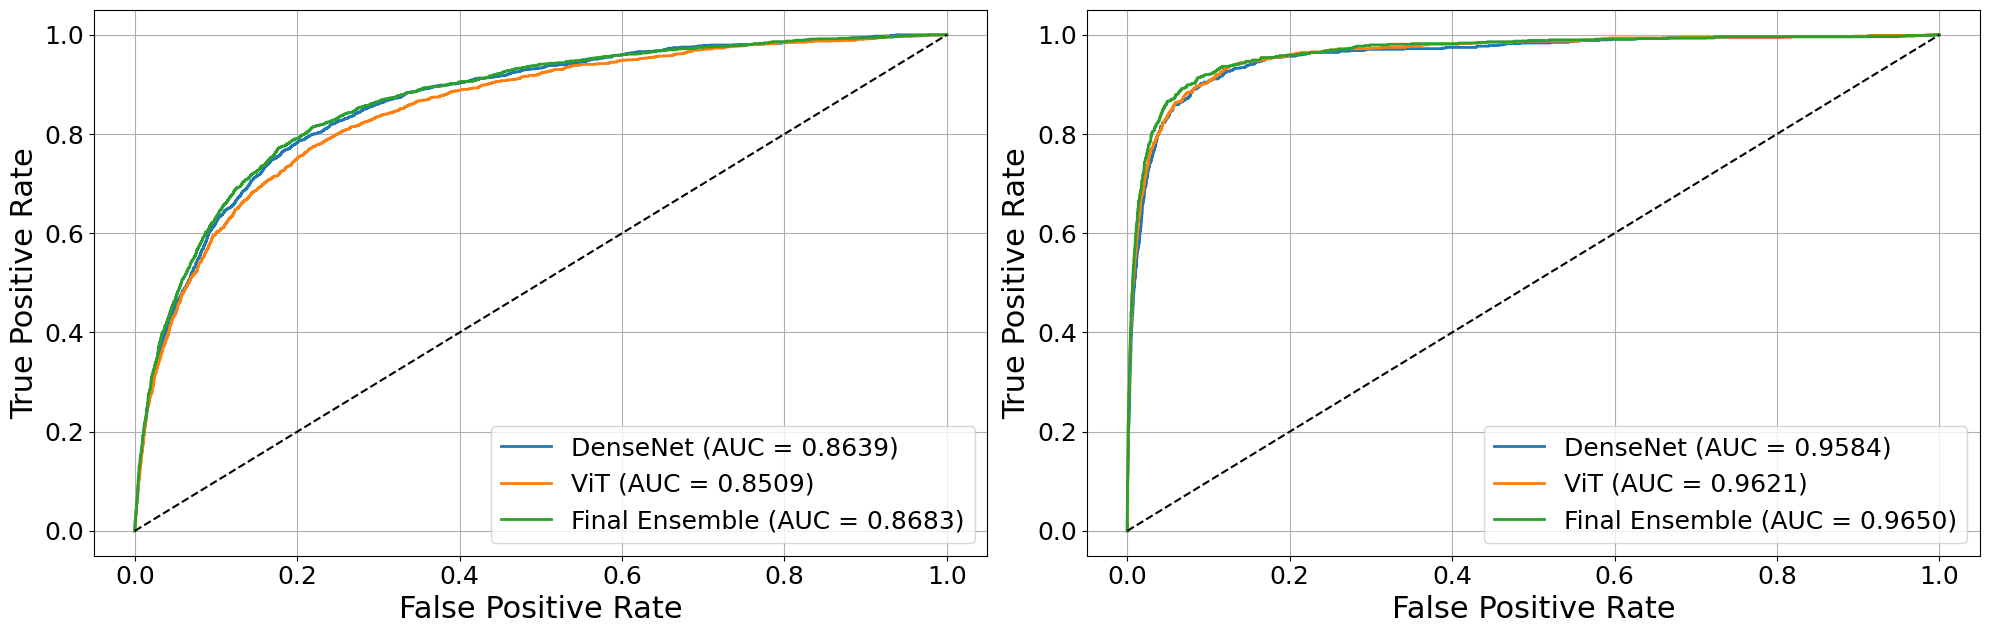


--- Finding Optimal Thresholds for ENSEMBLE (based on F1-Score) ---
Optimal threshold for 'Infiltration': 0.43 (F1-Score: 0.4880)
Optimal threshold for 'Effusion': 0.43 (F1-Score: 0.6679)

--- Classification Report for ENSEMBLE (with Optimal Thresholds) ---
       Class Precision Recall F1-Score  Support
Infiltration    0.4197 0.5828   0.4880     1745
    Effusion    0.6727 0.6633   0.6679      787
-------------------------------------------------------

--- Confusion Matrices for ENSEMBLE (with Optimal Thresholds) ---


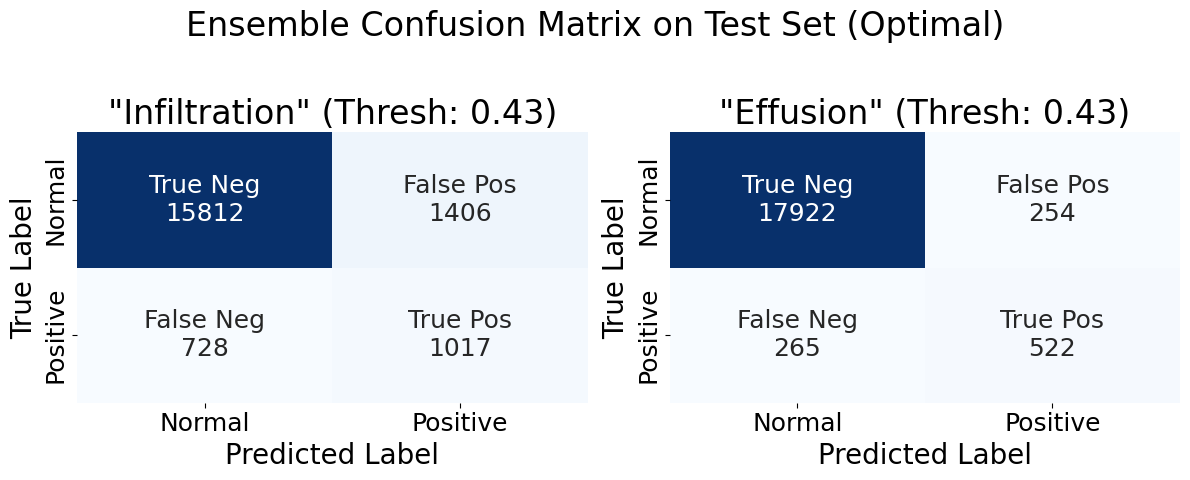


--- Side-by-Side Grad-CAM Analysis for Ensemble ---
Searching for specific samples in the test set...
  > Found sample for: Infiltration Only
  > Found sample for: Normal
  > Found sample for: Effusion Only
  > Found sample for: Infiltration & Effusion


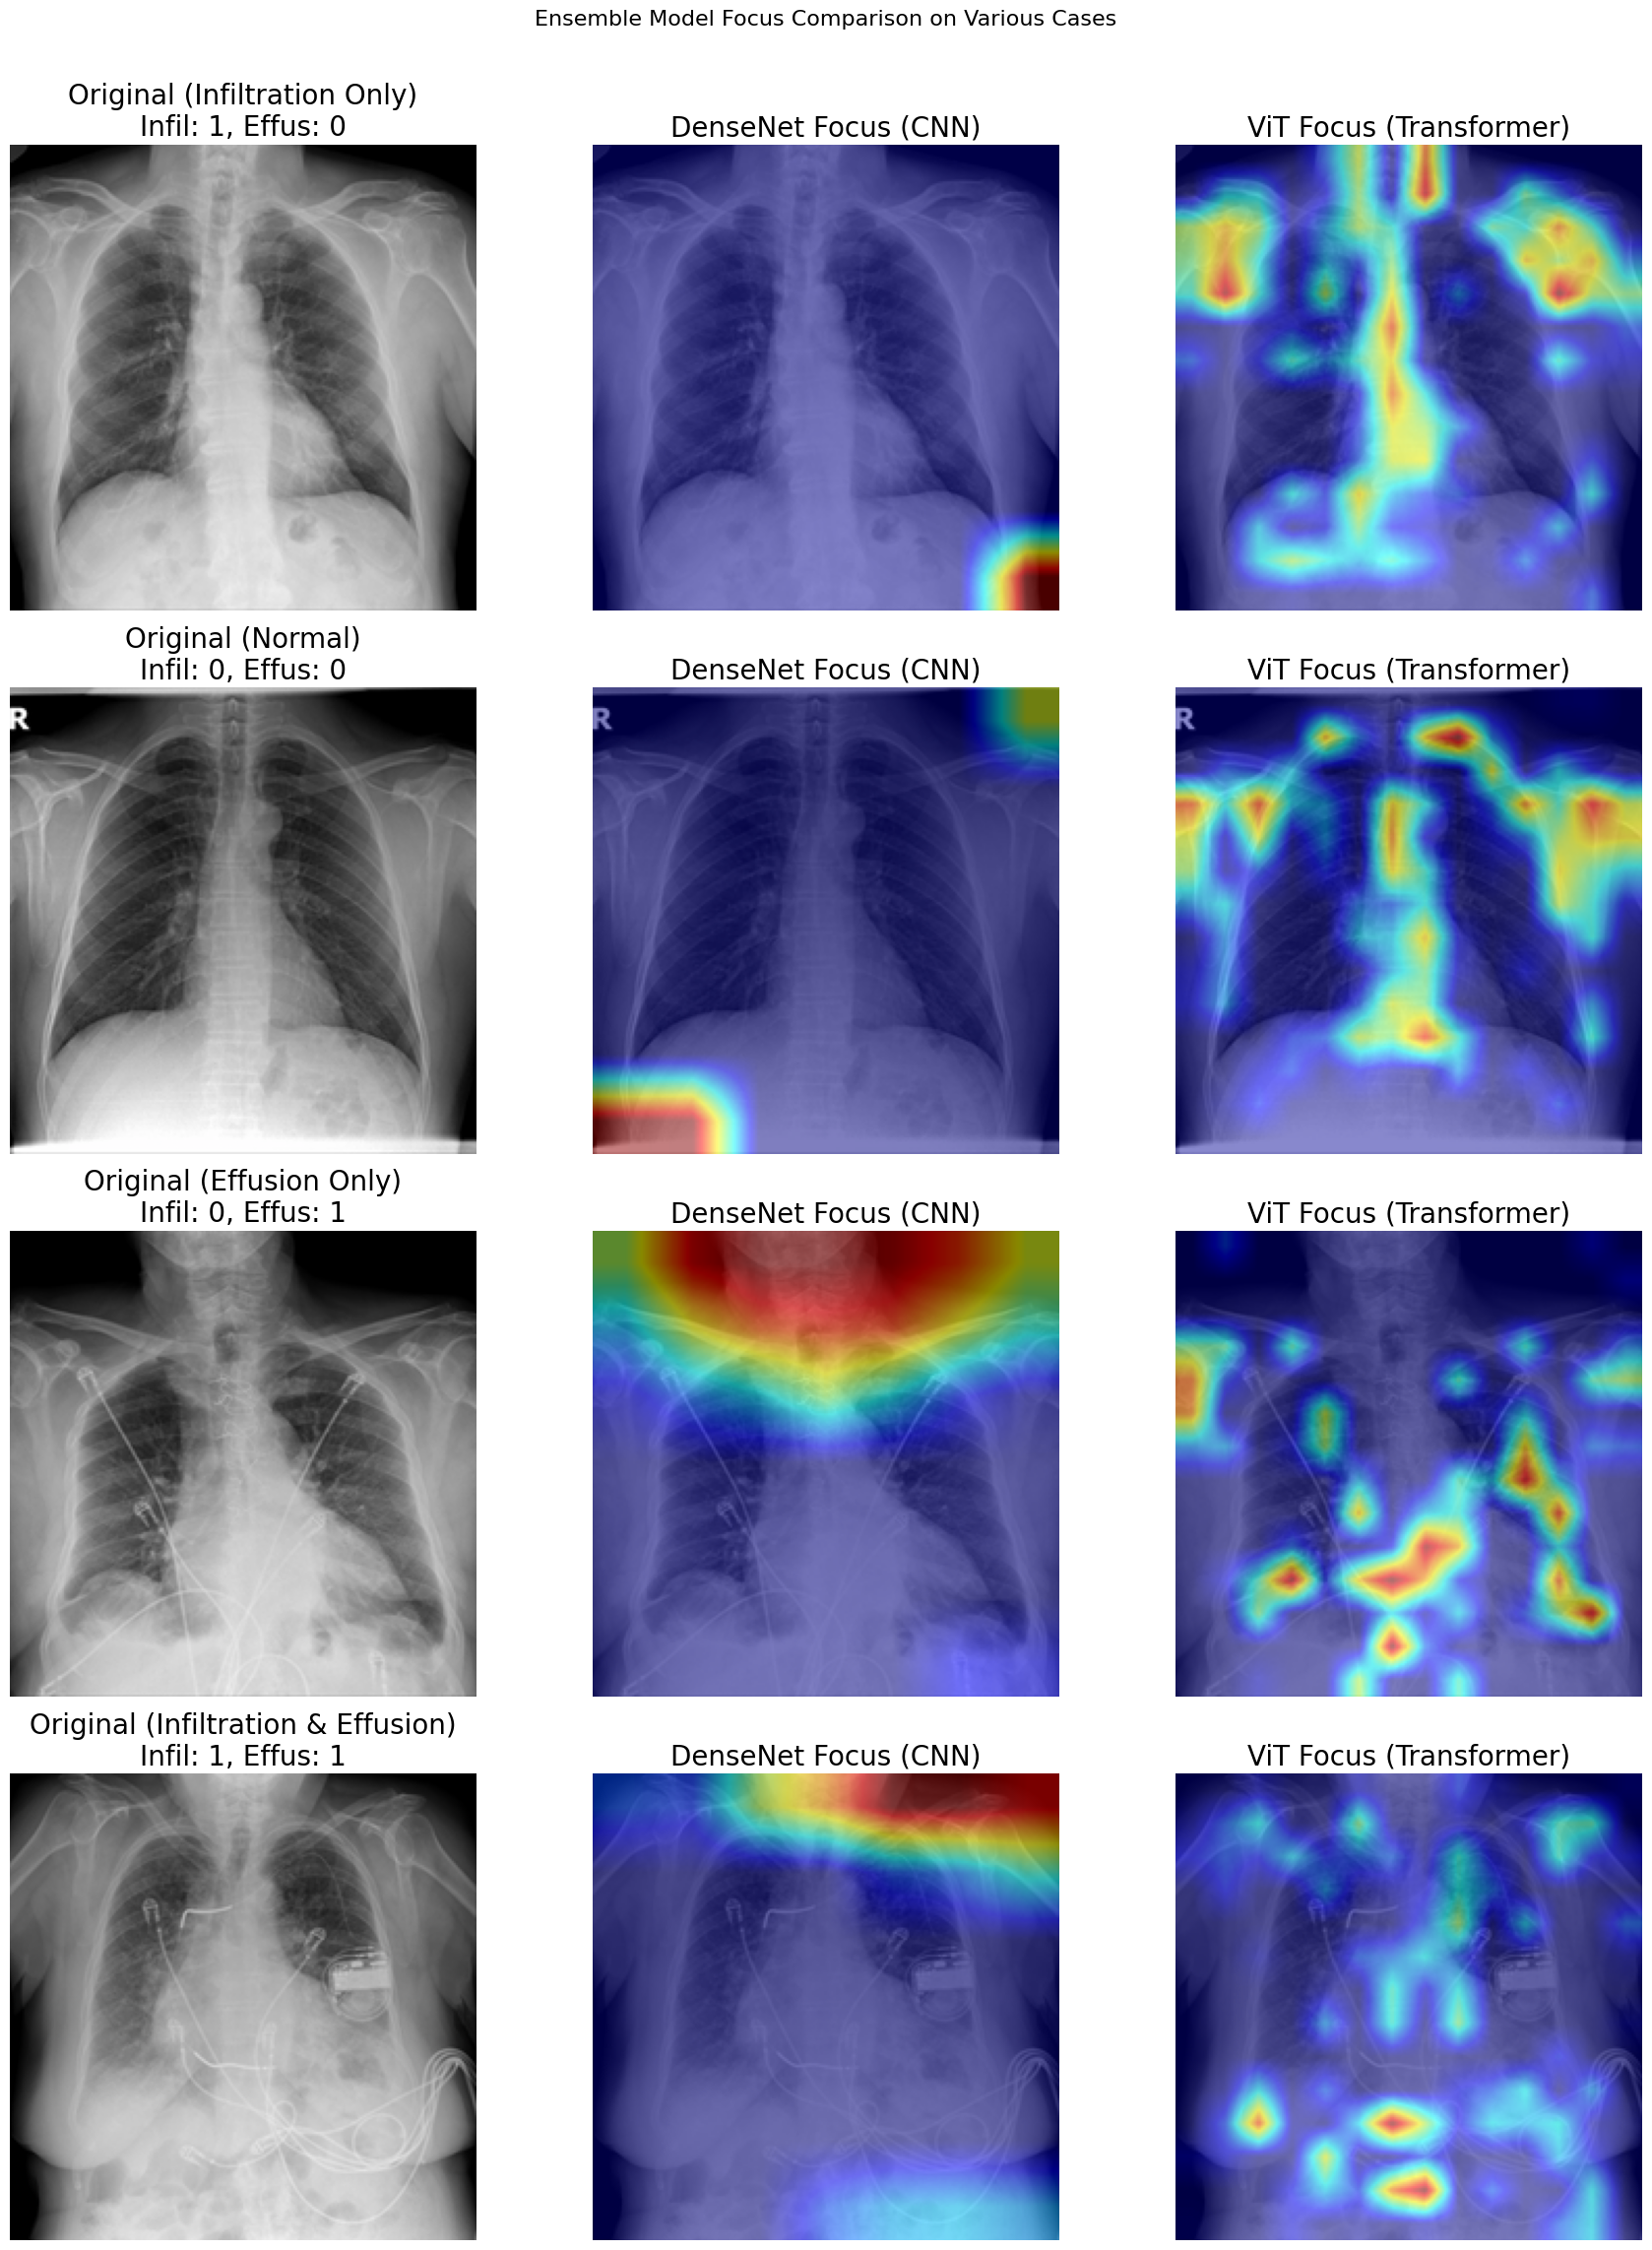

In [16]:
# Plotting ROC Curve Comparison
plt.figure(figsize=(20, 7))
for i, label_name in enumerate(CFG.TARGET_LABELS):
    plt.subplot(1, 2, i+1)
    for name, preds in zip(model_names, all_preds_list):
        valid_mask = ~np.isnan(true_labels[:, i])
        fpr, tpr, _ = roc_curve(true_labels[valid_mask, i], preds[valid_mask, i])
        auc = roc_auc_score(true_labels[valid_mask, i], preds[valid_mask, i])
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
    plt.xlabel('False Positive Rate', fontsize=22)
    plt.ylabel('True Positive Rate', fontsize=22)
    plt.legend(fontsize=18)
    plt.grid()

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('roc-curve.png', dpi=300, bbox_inches='tight')
plt.show()

evaluate_ensemble_with_optimal_thresholds(true_labels, preds_densenet, preds_vit, CFG.TARGET_LABELS)
visualize_ensemble_cam(model_densenet, model_vit, test_subset_densenet, test_subset_vit, DEVICE)

In [17]:
# Grad-CAM Exploration
def visualize_specific_pathologies(model_densenet, model_vit, dataset_densenet, dataset_vit, device, num_per_class=5):
    print(f"\n--- Displaying {num_per_class} examples for each pathology ---")

    np.random.seed(CFG.SEED)
    
    print("Searching for all positive samples in the test set...")
    infiltration_indices = []
    effusion_indices = []
    
    for i in range(len(dataset_densenet)):
        _, label = dataset_densenet[i]
        if int(label[0]) == 1:
            infiltration_indices.append(i)
        if int(label[1]) == 1:
            effusion_indices.append(i)
            
    print(f"Found {len(infiltration_indices)} Infiltration samples.")
    print(f"Found {len(effusion_indices)} Effusion samples.")

    num_infil_to_show = min(num_per_class, len(infiltration_indices))
    num_effus_to_show = min(num_per_class, len(effusion_indices))
    
    if num_infil_to_show > 0:
        infil_samples_idx = np.random.choice(infiltration_indices, num_infil_to_show, replace=False)
    else:
        infil_samples_idx = []
        
    if num_effus_to_show > 0:
        effus_samples_idx = np.random.choice(effusion_indices, num_effus_to_show, replace=False)
    else:
        effus_samples_idx = []

    indices_to_show = np.concatenate([infil_samples_idx, effus_samples_idx])
    
    if len(indices_to_show) == 0:
        print("No positive samples were found.")
        return

    cam_densenet = GradCAM(model=model_densenet, target_layers=[model_densenet.features.denseblock4.denselayer16.conv2])
    def reshape_transform_vit(tensor):
        result = tensor[:, 1:, :]; b, n, c = result.shape; h = w = int(n**0.5)
        return result.reshape(b, h, w, c).permute(0, 3, 1, 2)
    cam_vit = GradCAM(model=model_vit, target_layers=[model_vit.encoder.layers.encoder_layer_11.ln_1], reshape_transform=reshape_transform_vit)

    num_total_examples = len(indices_to_show)
    fig, axs = plt.subplots(num_total_examples, 3, figsize=(18, 6 * num_total_examples))
    if num_total_examples == 1: axs = np.array([axs])
    fig.suptitle(f"Grad-CAM Comparison for Specific Pathologies", fontsize=24)
    
    for i, idx in enumerate(indices_to_show):
        img_tensor_densenet, label = dataset_densenet[idx]
        img_tensor_vit, _ = dataset_vit[idx]
        input_densenet = img_tensor_densenet.unsqueeze(0).to(device)
        input_vit = img_tensor_vit.unsqueeze(0).to(device)

        is_infil_example = idx in infil_samples_idx
        target_class_index = 0 if is_infil_example else 1
        targets = [ClassifierOutputTarget(target_class_index)]
        
        cam_densenet_result = cam_densenet(input_tensor=input_densenet, targets=targets)[0, :]
        cam_vit_result = cam_vit(input_tensor=input_vit, targets=targets)[0, :]
        
        mean=torch.tensor([0.485,0.456,0.406]).view(3,1,1); std=torch.tensor([0.229,0.224,0.225]).view(3,1,1)
        rgb_img = (img_tensor_vit * std + mean).permute(1, 2, 0).numpy(); rgb_img = np.clip(rgb_img, 0, 1)
        vis_densenet = show_cam_on_image(rgb_img, cam_densenet_result, use_rgb=True)
        vis_vit = show_cam_on_image(rgb_img, cam_vit_result, use_rgb=True)
        
        example_type = "Infiltration Example" if is_infil_example else "Effusion Example"
        true_labels = f"Infil: {label[0]:.0f}, Effus: {label[1]:.0f}"
        original_idx = dataset_densenet.indices[idx]
        axs[i, 0].imshow(rgb_img); axs[i, 0].set_title(f"Original (Sample {original_idx})\n{example_type}\n{true_labels}", fontsize=26); axs[i, 0].axis('off')
        axs[i, 1].imshow(vis_densenet); axs[i, 1].set_title("DenseNet Focus", fontsize=32); axs[i, 1].axis('off')
        axs[i, 2].imshow(vis_vit); axs[i, 2].set_title("ViT Focus", fontsize=32); axs[i, 2].axis('off')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig('gradcam-explore.png', dpi=300, bbox_inches='tight')
    plt.show()


--- Displaying 5 examples for each pathology ---
Searching for all positive samples in the test set...
Found 1745 Infiltration samples.
Found 787 Effusion samples.


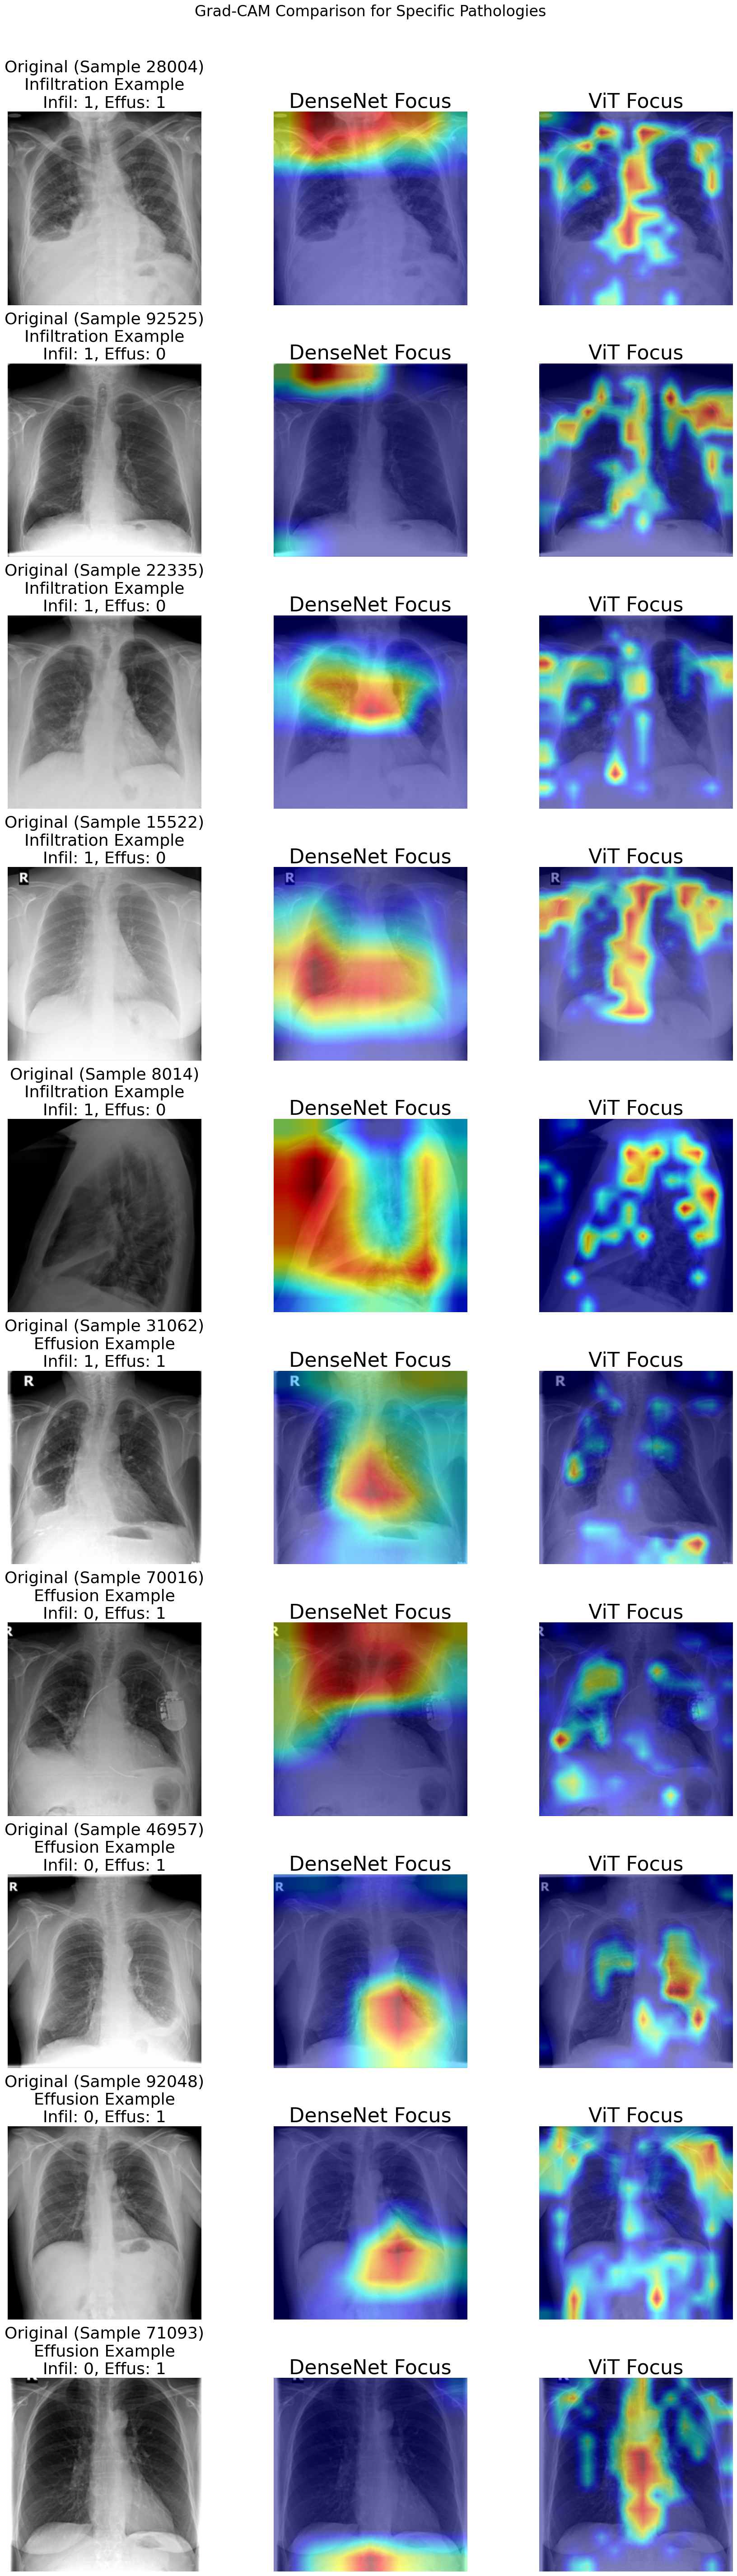

In [18]:
visualize_specific_pathologies(
    model_densenet, 
    model_vit, 
    test_subset_densenet, 
    test_subset_vit, 
    DEVICE, 
    num_per_class=5
)